# Cluster Analysis IV

So far we have seen partitioning (hard clustering) methods.

In some application scenario partitioning is a too strong assumption. One would rather prefer to have a degree of inclusion in a given cluster.

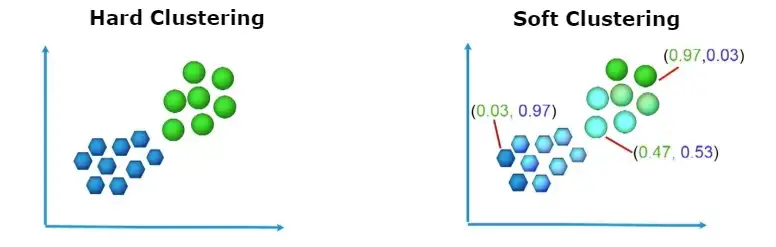

Given a dataset of $m$ instances ${\cal D} =\{x_1, \ldots, x_m\}$, and a set of i $k$ clusters $ùê∂=\{C_1, \ldots, C_k\}$, we denote with $w_{ij}$ the membership degree of instance $x_i$ to cluster $C_j$.

Subject to the following conditions:

 1. for each instance $x_i$: $\sum_{j=1}^k w_{ij} = 1$
 1. for each cluster $C_j$: $0\ <\ \sum_{i=1}^m w_{ij}\ <\ m$

The values $w_{ij}$ define a **fuzzy clustering**.

# Fuzzy C-Means

We may recall the objective function of the K-Means algorithm:

$$
E = \sum\limits_{j=1}^{k} \sum_{x_i \in C_j}  \textsf{dist}(x_i,c_j)^2
$$

Now every point contributes according to its membership, therefore:

$$
E = \sum\limits_{j=1}^{k} \sum_{i=1}^{m}  w_{ij}^p\ \textsf{dist}(x_i,c_j)^2
$$

The parameter $p$ controls the fuzzy-ness. When $p$ grows we have more fuzzyness.

Hereinafter we use $p=2$.


Revisiting KMeans we need to adjust the two steps of computing centroids and memberships.

The centroids are updated as follows:

$$ c_j = \frac{\sum_{i=1}^m w_{ij}^2 x_i}{\sum_{i=1}^m w_{ij}^2 } $$

The above is simply the normalized mean of the point in the dataset weighted by their membership. If $w_{ij}$ is either 0 or 1 this is equivalent to K-Means.

The memberships are updated by computing the new $w_{ij}$ values according to the formula (not derived here):

$$\left.  w_{ij} = \frac{1}{ \textsf{dist}(x_i,c_j)^2} \middle/ \sum_{q=1}^k \frac{1}{ \textsf{dist}(x_i,c_q)^2} \right. $$

Suggested implementation: https://github.com/omadson/fuzzy-c-means
Example: https://www.kaggle.com/code/rafaelsaraivacampos/clustering-hand-written-digits-with-fuzzy-k-means

In [1]:
#import sys
#!{sys.executable} -m pip install fuzzy-c-means

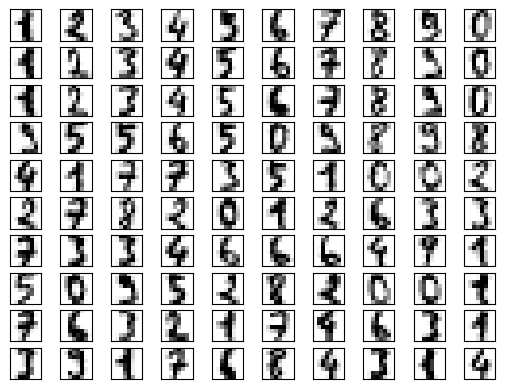

In [2]:
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn.preprocessing import minmax_scale
from matplotlib import pyplot as plt
from fcmeans import FCM
import numpy as np


digits = load_digits()

X = digits['data']
X = minmax_scale(X,feature_range=(0,1))
npixels = int(np.sqrt(X.shape[1]))

labels = digits['target']

images = digits['images']
for i in range(1,101):
    ax = plt.subplot(10,10,i)
    ax.imshow(images[i],cmap='Greys')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [21]:
fcm=FCM(n_clusters=10,
        m = 1.1, # fuzzy partition matrix exponent -> degree of fuzziness
        max_iter=100,
        error = 1e-09
       )

fcm.fit(X)
centers = fcm.centers
clusters = fcm.predict(X)

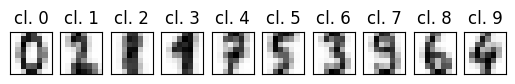

In [22]:
for i in range(10):
    ax = plt.subplot(1,10,i+1)
    ax.imshow(np.reshape(fcm.centers[i],[npixels,npixels]),cmap='Greys')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(title="cl. "+str(i))


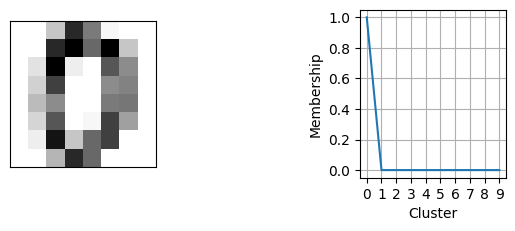

In [23]:
ax = plt.subplot(2,3,1)
ax.imshow(np.reshape(X[0],[npixels,npixels]),cmap='Greys')
ax.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

ax = plt.subplot(2,3,3)
ax.plot(fcm.soft_predict(X[[0]])[0]);
ax.grid(visible=True)
ax.set_xticks(list(range(10)))    
ax.set(xlabel='Cluster',ylabel='Membership');

In [24]:
i1 = np.where(labels==9)  
i2 = np.where(clusters==1) # 3 
S = list(set(i2[0]).intersection(set(i1[0])))

for i in range(len(S[:4])):
    ax = plt.subplot(1,len(S),i+1)
    ax.imshow(np.reshape(X[S[i]],[npixels,npixels]),cmap='Greys')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
for i in range(len(S[:4])):
    plt.figure()

    ax = plt.subplot(2,3,1)
    ax.imshow(np.reshape(X[S[i]],[npixels,npixels]),cmap='Greys')
    ax.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    ax = plt.subplot(2,3,3)
    ax.plot(fcm.soft_predict(X[S])[i]);
    ax.grid(visible=True)
    ax.set_xticks(list(range(10)))    
    ax.set(xlabel='Cluster',ylabel='Membership (log-scale)')

# Self-Organizing Map (SOM)



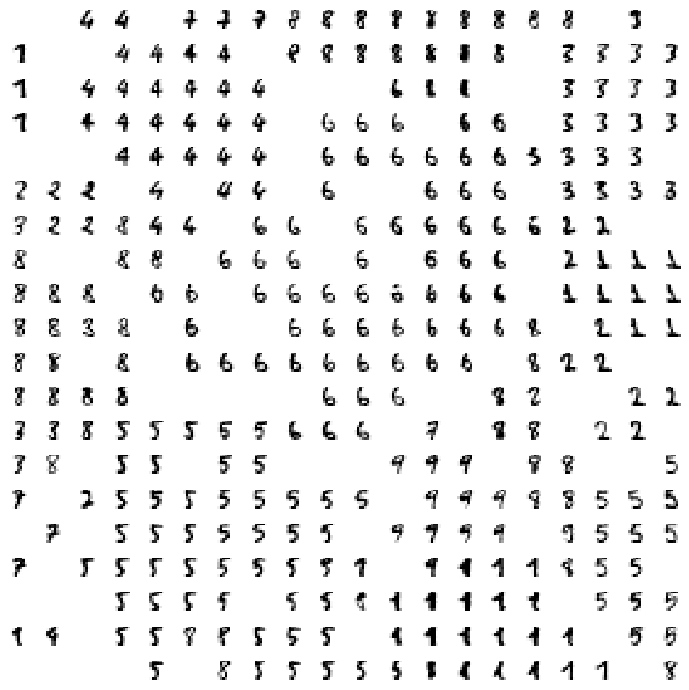

SOMs are centroid-based clustering algorithms, where centroids have a spatial organization (e.g. on 2D rectangle). In addition close centroids are similar. In this regards, a 2D SOM is a projection of the high-dimensional dataset onto a 2D surface trying to preserve similarity.

This is both a clustering and a visualization technique.

The algoirthms is as follows:

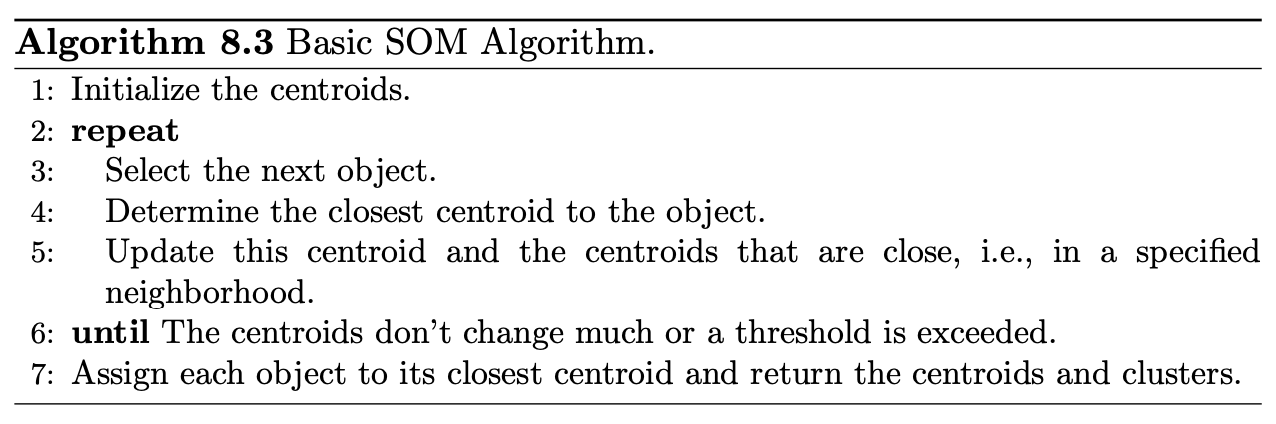

The **initialization** consists in deciding the map size (2D, square rectangular) and the shape (cells can be hexagonal). Then each cell on the map is a centroid, typically initialized as a random datapoint. Eventually, a set of centroids is layed onto a low-dimensional map.

**The algorithm updates centroids so that the map can be considered a low-dimensional view of the dataset.**

The most complex is step 5: **update**. The goal is to make each centroid more similar to points in the dataset that are close to it. 

Each iteration $t$ is an epoch of the training process.
Given the current point $p(t)$, the nearest centroid $m(t)$ (a.k.a. the winner), the centroid is updated as follows:

$$
m_j(t + 1) = m_j(t) + h_j(t)(p(t) ‚àí m_j(t))
$$

where $h_j$ is a centroid neighbouring function that weights the update. Note that in principle all centroids might be updated. A typical $h$ is:

$$
hj (t) = Œ±(t)\ \textrm{if}\ \textsf{dist}(m_j , m_k ) \leq \textrm{threshold,}\ 0\ \textrm{otherwise}
$$

where the distance $\textsf{dist}(m_j , m_k)$ is measured on the SOM grid and not in the original feature space and $0 < \alpha_t < 1$ decreases over epochs.




Suggested implementation: https://github.com/JustGlowing/minisom